In [1]:
from __future__ import absolute_import, print_function

import argparse, json, os, requests, sys, time
from io import BytesIO
from os.path import join, isfile
from PIL import Image

#from mxnet.gluon.model_zoo import vision
import numpy as np
from matplotlib import pyplot as plt

import tvm
from tvm import te
from tvm import rpc, autotvm, relay
from tvm.contrib import graph_runtime, utils, download
from tvm.relay import transform

import vta
from vta.testing import simulator
from vta.top import graph_pack

import torch
import torchvision
from tvm.contrib.download import download_testdata
from torch import nn



# Make sure that TVM was compiled with RPC=1
assert tvm.runtime.enabled("rpc")

/home/srchand/anaconda3/envs/tvm-build-il-2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = vta.get_env()

# Set ``device=arm_cpu`` to run inference on the CPU
# or ``device=vta`` to run inference on the FPGA.
device = "vta"
target = env.target if device == "vta" else env.target_vta_cpu

# Dictionary lookup for when to start/end bit packing
pack_dict = {
    #"resnet18_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet34": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet50": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet101": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "vgg16":    ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet34_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet34_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet50_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet101_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
}

# Name of Gluon model to compile
# The ``start_pack`` and ``stop_pack`` labels indicate where
# to start and end the graph packing relay pass: in other words
# where to start and finish offloading to VTA.
#model = "resnet18_v1"
#assert model in pack_dict
model = "resnet18"

In [3]:
remote = None
if env.TARGET not in ["sim", "tsim", "intelfocl"]:

    # Get remote from tracker node if environment variable is set.
    # To set up the tracker, you'll need to follow the "Auto-tuning
    # a convolutional network for VTA" tutorial.
    tracker_host = os.environ.get("TVM_TRACKER_HOST", None)
    tracker_port = os.environ.get("TVM_TRACKER_PORT", None)
    # Otherwise if you have a device you want to program directly from
    # the host, make sure you've set the variables below to the IP of
    # your board.
    #device_host = os.environ.get("VTA_RPC_HOST", "192.168.2.99")
#     device_host = "192.168.2.99"
    device_host="10.100.83.40"

    device_port = os.environ.get("VTA_RPC_PORT", "9091")
    if not tracker_host or not tracker_port:
        remote = rpc.connect(device_host, int(device_port))
    else:
        remote = autotvm.measure.request_remote(
            env.TARGET, tracker_host, int(tracker_port), timeout=10000
        )

    # Reconfigure the JIT runtime and FPGA.
    # You can program the FPGA with your own custom bitstream
    # by passing the path to the bitstream file instead of None.
    reconfig_start = time.time()
    vta.reconfig_runtime(remote)
    #vta.program_fpga(remote, bitstream="/home/srchand/Desktop/overlays/vta_il/vta_apm_maxigp0_wrapper.bit")
    #vta.program_fpga(remote, bitstream=None)
#     vta.program_fpga(remote, bitstream="/home/srchand/Desktop/research/TVM_Intel_Fork/tvm/vta/sri_scripts/bitstreams/vta_zcu104_wrapper.bit")
#     vta.program_fpga(remote, bitstream="/mnt/hgfs/vmware_ubuntu_sf/bitstreams/vta_axi_sniffer_uart_fifo_thres_100.bit")

    reconfig_time = time.time() - reconfig_start
    print("Reconfigured FPGA and RPC runtime in {0:.2f}s!".format(reconfig_time))

# In simulation mode, host the RPC server locally.
else:
    remote = rpc.LocalSession()

    if env.TARGET in ["intelfocl"]:
        # program intelfocl aocx
        vta.program_fpga(remote, bitstream="vta.bitstream")

# Get execution context from remote
ctx = remote.ext_dev(0) if device == "vta" else remote.cpu(0)

Reconfigured FPGA and RPC runtime in 0.01s!


In [4]:
CPU_exec = nn.Sequential(nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1),
                                       padding=(1, 1)), nn.ReLU(inplace=True))

In [5]:
VTA_exec = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1),
                                       padding=(1, 1)), nn.ReLU(inplace=True), nn.Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1),
                                       padding=(1, 1)), nn.ReLU(inplace=True))

In [6]:
last_layer = nn.AdaptiveAvgPool2d((1, 1))

In [7]:
model = nn.Sequential(CPU_exec, VTA_exec, last_layer)

In [8]:
import glob
schedule_log_files = glob.glob(r'/home/srchand/Desktop/research/TVM_Intel_Fork/tvm/vta/sri_scripts/logs/tuning_logs/*.log')

In [9]:
with autotvm.tophub.context(target, extra_files=schedule_log_files):
    
    input_name = "input0"

    input_shape = [1, 3, 28, 28]
    input_data = torch.randn(input_shape)

    scripted_model = torch.jit.trace(model, input_data).eval()
    shape_list = [(input_name, input_shape)]
    

    # Measure build start time
    build_start = time.time()

    # Start front end compilation
    mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)
    
    

    #mod, params = relay.frontend.from_mxnet(net, shape_dict)
    

    if target.device_name == "vta":
        # Perform quantization in Relay
        # Note: We set opt_level to 3 in order to fold batch norm
        with tvm.transform.PassContext(opt_level=3):
            with relay.quantize.qconfig(global_scale=8.0, skip_conv_layers=[0]):
                mod = relay.quantize.quantize(mod, params=params)
#                 print(mod.astext(show_meta_data=False))
#                 print(apput)
            # Perform graph packing and constant folding for VTA target
            assert env.BLOCK_IN == env.BLOCK_OUT
            # do device annotation if target is intelfocl or sim
            relay_prog = graph_pack(
                mod["main"],
                env.BATCH,
                env.BLOCK_IN,
                env.BLOCK_OUT,
                env.WGT_WIDTH,
                start_name='cast',
                start_name_idx=7,
                stop_name='nn.adaptive_avg_pool2d',
                #start_name="cast",
                #stop_name="reshape",
                #start_name='nn.max_pool2d',
                #stop_name='add',
                #start_name_idx=8,
                #stop_name_idx=227,
                device_annot=(env.TARGET == "intelfocl"),
            )
    else:
        relay_prog = mod["main"]

    # Compile Relay program with AlterOpLayout disabled
    if target.device_name != "vta":
        with tvm.transform.PassContext(opt_level=3, disabled_pass={"AlterOpLayout"}):
            graph, lib, params = relay.build(
                relay_prog, target=target, params=params, target_host=env.target_host
            )
    else:
        if env.TARGET == "intelfocl":
            # multiple targets to run both on cpu and vta
            target = {"cpu": env.target_vta_cpu, "ext_dev": target}
        with vta.build_config(opt_level=3, disabled_pass={"AlterOpLayout"}):
            graph, lib, params = relay.build(
                relay_prog, target=target, params=params, target_host=env.target_host
            )

    # Measure Relay build time
    build_time = time.time() - build_start
    print("custom model " + " inference graph built in {0:.2f}s!".format(build_time))

    # Send the inference library over to the remote RPC server
    temp = utils.tempdir()
    lib.export_library(temp.relpath("graphlib.tar"))
    remote.upload(temp.relpath("graphlib.tar"))
    lib = remote.load_module("graphlib.tar")

    if env.TARGET == "intelfocl":
        ctxes = [remote.ext_dev(0), remote.cpu(0)]
        m = graph_runtime.create(graph, lib, ctxes)
    else:
        # Graph runtime
        m = graph_runtime.create(graph, lib, ctx)

Cannot find config for target=ext_dev -keys=vta,cpu -device=vta -model=zcu104_1x16x16_i8w8a32_15_15_18_17, workload=('conv2d_nchw_spatial_pack.arm_cpu', ('TENSOR', (1, 3, 28, 28), 'float32'), ('TENSOR', (16, 3, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32'). A fallback configuration is used, which may bring great performance regression.
/tmp/ipykernel_225999/3350765981.py:65: DeprecationWarning: legacy graph runtime behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_runtime.GraphModule for the  new recommended usage.
  graph, lib, params = relay.build(


custom model  inference graph built in 3.43s!


File synset.txt exists, skip.


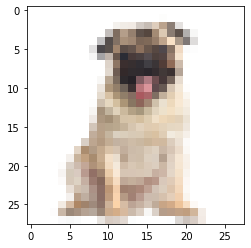

In [10]:
categ_url = "https://github.com/uwsampl/web-data/raw/main/vta/models/"
categ_fn = "synset.txt"
download.download(join(categ_url, categ_fn), categ_fn)
synset = eval(open(categ_fn).read())

# Download test image
image_url = "https://homes.cs.washington.edu/~moreau/media/vta/cat.jpg"
image_fn = "pug.jpg"
#download.download(image_url, image_fn)

# Prepare test image for inference
image = Image.open(image_fn).resize((28, 28))
plt.imshow(image)
plt.show()
image = np.array(image) - np.array([123.0, 117.0, 104.0])
image /= np.array([58.395, 57.12, 57.375])
image = image.transpose((2, 0, 1))
image = image[np.newaxis, :]
image = np.repeat(image, env.BATCH, axis=0)

# Set the network parameters and inputs
m.set_input(**params)
m.set_input(input_name, image)

In [13]:
m.run()